## Libraries

In [1]:
import pandas as pd 
import numpy as np 
from sklearn import * 
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve, f1_score
import seaborn as sns
from xgboost import XGBClassifier
import shap
import os



/Users/alekhya/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Helper Functions

In [2]:
# WOE (Weight of Evidence) calculation
def calculate_woe_iv(df, feature, target, bins=5):
    # Bin the feature
    binned_x = pd.qcut(df[feature], q=bins, duplicates='drop')
    temp_df = pd.DataFrame({'bin': binned_x, 'target': target})

    # Group by bin and calculate counts
    grouped = temp_df.groupby('bin')['target'].agg(['count', 'sum'])
    grouped.columns = ['total', 'bads']
    grouped['goods'] = grouped['total'] - grouped['bads']

    # Calculate distributions
    total_goods = grouped["goods"].sum()
    total_bads = grouped["bads"].sum()
    grouped["dist_good"] = grouped["goods"] / total_goods
    grouped["dist_bad"] = grouped["bads"] / total_bads

    # Compute WOE and IV
    grouped['woe'] = np.log(grouped['dist_good'] / grouped['dist_bad']).replace([np.inf, -np.inf], 0)
    grouped['iv'] = (grouped["dist_good"] - grouped["dist_bad"]) * grouped["woe"]

    # Return bin to WOE mapping and IV score
    woe_map = grouped["woe"].to_dict()
    iv = grouped["iv"].sum()
    return woe_map, iv


## Clean and Preprocess Data

In [3]:
# Reading the data
df = pd.read_csv("GiveMeSomeCredit/cs-training.csv")
df = df.drop(columns=["Unnamed: 0"], errors = "ignore")
display(df.head())

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
# Check for missing values
print(df.isnull().sum())

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


In [5]:
# check type
df.dtypes

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

In [6]:
# Proportion of target variable
df['SeriousDlqin2yrs'].value_counts(normalize=True)

SeriousDlqin2yrs
0    0.93316
1    0.06684
Name: proportion, dtype: float64

In [7]:
# Splitting data
X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [8]:
# Impute data -> Handling Missing Values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.fit_transform(X_test)
# Converting array to df
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns, index=X_test.index)

# Weight of Evidence (WOE) -> not for tree based models
X_train_woe = pd.DataFrame(index=X_train_imputed.index)
X_test_woe = pd.DataFrame(index=X_test_imputed.index)
woe_maps = {}
iv_scores = {}

for col in X_train_imputed.columns:
    try:
        # Calculate WOE map and IV
        woe_map, iv = calculate_woe_iv(X_train_imputed, col, y_train)
        iv_scores[col] = iv
        woe_maps[col] = woe_map

        # Bin and map on train
        train_bins = pd.qcut(X_train_imputed[col], q=5, duplicates='drop')
        X_train_woe[col] = train_bins.map(woe_map)

        # Use the same bin edges on test set
        bin_edges = train_bins.cat.categories
        test_bins = pd.cut(X_test_imputed[col], bins=bin_edges, include_lowest=True)
        X_test_woe[col] = test_bins.map(woe_map)
        
    except Exception as e:
        print(f"Skipping {col}: {e}")


# # Scaling Data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_woe)
# X_test_scaled = scaler.fit_transform(X_test_woe)



/var/folders/x2/klg0381s1817zyd0xzkrhgfh0000gn/T/ipykernel_86328/2516039334.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = temp_df.groupby('bin')['target'].agg(['count', 'sum'])
/var/folders/x2/klg0381s1817zyd0xzkrhgfh0000gn/T/ipykernel_86328/2516039334.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = temp_df.groupby('bin')['target'].agg(['count', 'sum'])
/var/folders/x2/klg0381s1817zyd0xzkrhgfh0000gn/T/ipykernel_86328/2516039334.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain 

## Model Training

In [9]:
# Logistic regression to start off

lr = LogisticRegression(solver='liblinear')
lr.fit(X_train_woe, y_train)

# Predictions
y_pred = lr.predict(X_test_woe)
y_pred_proba = lr.predict_proba(X_test_woe)[:, 1]

# AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

AUC Score: 0.7872
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     27995
           1       0.00      0.00      0.00      2005

    accuracy                           0.93     30000
   macro avg       0.47      0.50      0.48     30000
weighted avg       0.87      0.93      0.90     30000

Confusion Matrix:
[[27995     0]
 [ 2005     0]]


/Users/alekhya/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alekhya/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alekhya/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Plot ROC curve

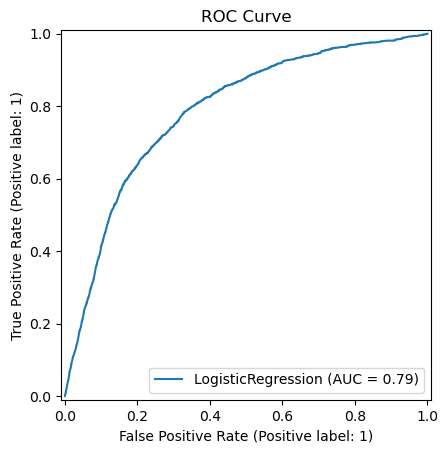

In [10]:
RocCurveDisplay.from_estimator(lr, X_test_woe, y_test)
plt.title('ROC Curve')
plt.savefig("figures/roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

## Optimizing Threshold

Model doesn't classify anyone as bad, as a result false negatives are high, threshold is too strict -> need to reduct threshold.

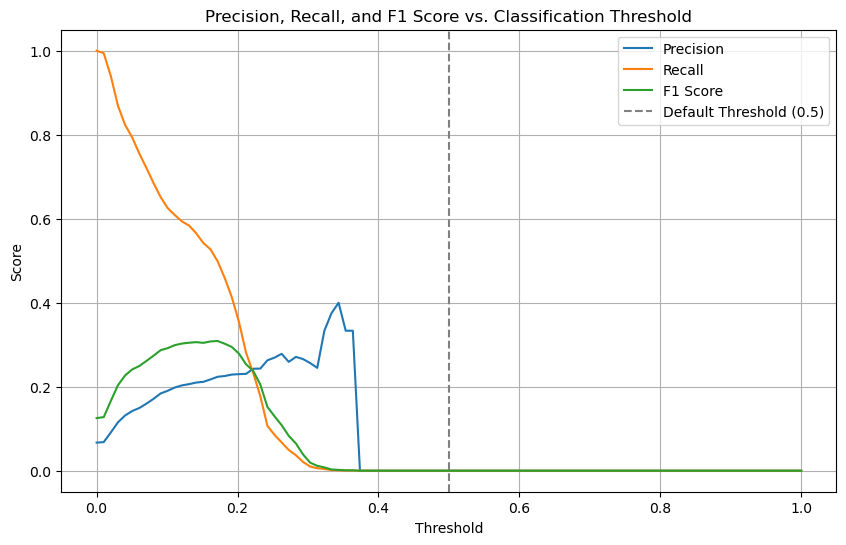

In [11]:
# Plotting Precision-Recall & F1 Across Thresholds

thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
f1s = []

for t in thresholds:
    y_pred_thresh = (y_pred_proba >= t).astype(int)
    p = np.sum((y_pred_thresh == 1) & (y_test == 1)) / max(np.sum(y_pred_thresh == 1), 1)
    r = np.sum((y_pred_thresh == 1) & (y_test == 1)) / np.sum(y_test == 1)
    f1s.append(f1_score(y_test, y_pred_thresh))
    precisions.append(p)
    recalls.append(r)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Classification Threshold')
plt.legend()
plt.grid(True)
plt.savefig("figures/threshold.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Based on plot choosing threshold
best_threshold = 0.14
y_pred_final = (y_pred_proba >= best_threshold).astype(int)

In [13]:
print("Classification Report (Custom Threshold):")
print(classification_report(y_test, y_pred_final))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

Classification Report (Custom Threshold):
              precision    recall  f1-score   support

           0       0.96      0.85      0.90     27995
           1       0.21      0.57      0.31      2005

    accuracy                           0.83     30000
   macro avg       0.59      0.71      0.60     30000
weighted avg       0.91      0.83      0.86     30000

Confusion Matrix:
[[23710  4285]
 [  869  1136]]


## Visualizing Results

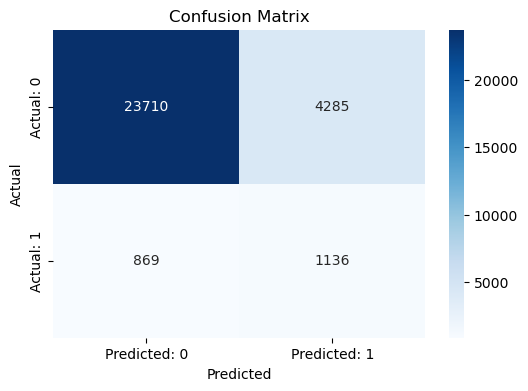

In [14]:
cm = confusion_matrix(y_test, y_pred_final)
labels = ["Non-Default (0)", "Default (1)"]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted: 0", "Predicted: 1"],
            yticklabels=["Actual: 0", "Actual: 1"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.savefig("figures/cm_lr.png", dpi=300, bbox_inches='tight')
plt.show()


## Trying Boosting Models to Improve Recall

In [15]:
# Calculate scale_pos_weight = (negatives/positives)
scale = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize XGBoost with class imbalance parameter
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight = scale,
    use_label_encoder=False,
    eval_metric = 'logloss',
    random_state=42
)

# Fit the model
xgb.fit(X_train_imputed, y_train)   #woe not needed for xgboost

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## Prediction & Evaluation

In [16]:
# Predict
y_pred_proba_xgb = xgb.predict_proba(X_test_imputed)[:, 1]
y_pred_xgb = xgb.predict(X_test_imputed)

# Metrics
print("AUC Score:", roc_auc_score(y_test, y_pred_proba_xgb))
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

AUC Score: 0.8685554465328018
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     27995
           1       0.22      0.78      0.34      2005

    accuracy                           0.80     30000
   macro avg       0.60      0.79      0.61     30000
weighted avg       0.93      0.80      0.84     30000

Confusion Matrix:
[[22326  5669]
 [  446  1559]]


### Best Threshold

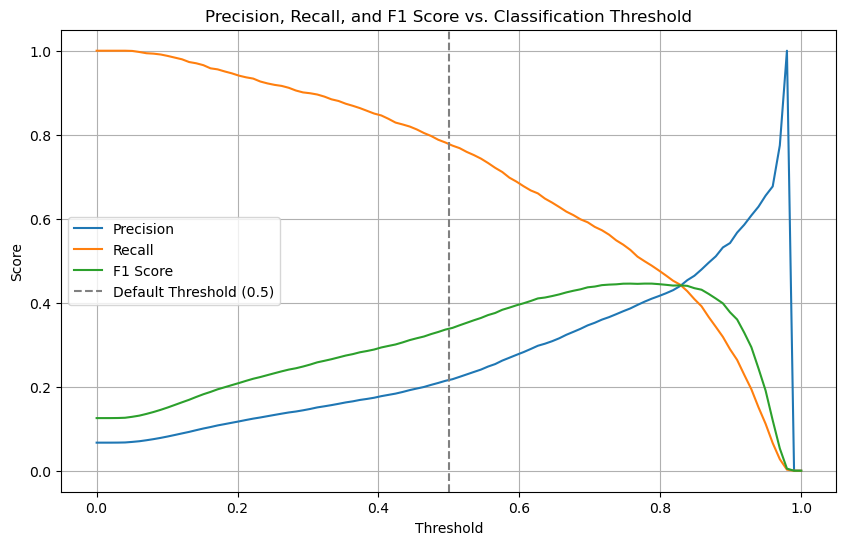

In [17]:
# Plotting Precision-Recall & F1 Across Thresholds

thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
f1s = []

for t in thresholds:
    y_pred_thresh = (y_pred_proba_xgb >= t).astype(int)
    p = np.sum((y_pred_thresh == 1) & (y_test == 1)) / max(np.sum(y_pred_thresh == 1), 1)
    r = np.sum((y_pred_thresh == 1) & (y_test == 1)) / np.sum(y_test == 1)
    f1s.append(f1_score(y_test, y_pred_thresh))
    precisions.append(p)
    recalls.append(r)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Classification Threshold')
plt.legend()
plt.grid(True)
plt.savefig("figures/threshold_xgb.png", dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# Based on plot choosing threshold
best_threshold = 0.77
y_pred_final_xgb = (y_pred_proba_xgb >= best_threshold).astype(int)

In [19]:
# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_final_xgb))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final_xgb))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     27995
           1       0.40      0.51      0.44      2005

    accuracy                           0.92     30000
   macro avg       0.68      0.73      0.70     30000
weighted avg       0.93      0.92      0.92     30000

Confusion Matrix:
[[26441  1554]
 [  987  1018]]


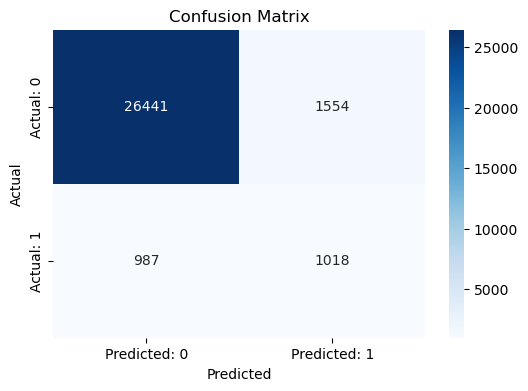

In [20]:
cm = confusion_matrix(y_test, y_pred_final_xgb)
labels = ["Non-Default (0)", "Default (1)"]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted: 0", "Predicted: 1"],
            yticklabels=["Actual: 0", "Actual: 1"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.savefig("figures/cm_xgb.png", dpi=300, bbox_inches='tight')
plt.show()

## Feature Importance

 97%|=================== | 29159/30000 [00:29<00:00]       

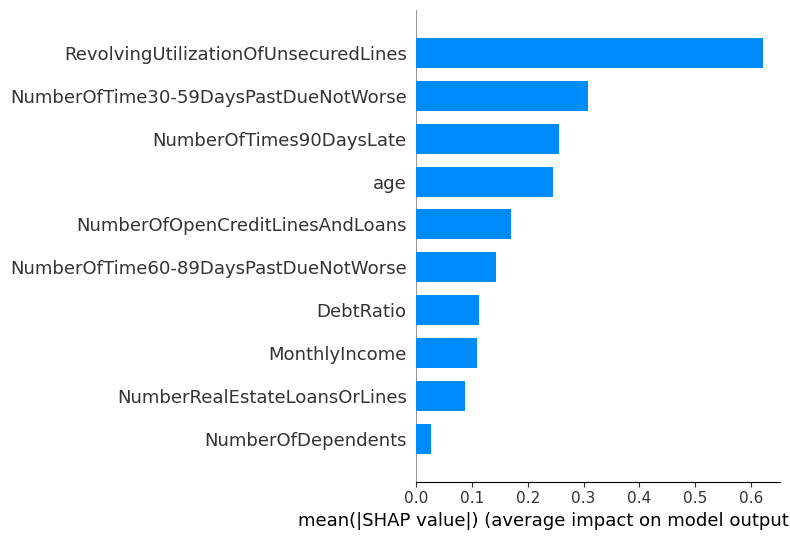

In [21]:
# Train a SHAP explainer on XGBoost model and training data
explainer = shap.Explainer(xgb, X_train_imputed)
shap_values = explainer(X_test_imputed)

plt.figure()    # start new figure context
# Global explanation: which features matter overall
shap.summary_plot(shap_values, X_test_imputed, plot_type='bar')
plt.title("SHAP Summary Plot (Bar)")
plt.savefig("figures/shap_summary_bar.png", bbox_inches='tight', dpi=300)
plt.close()



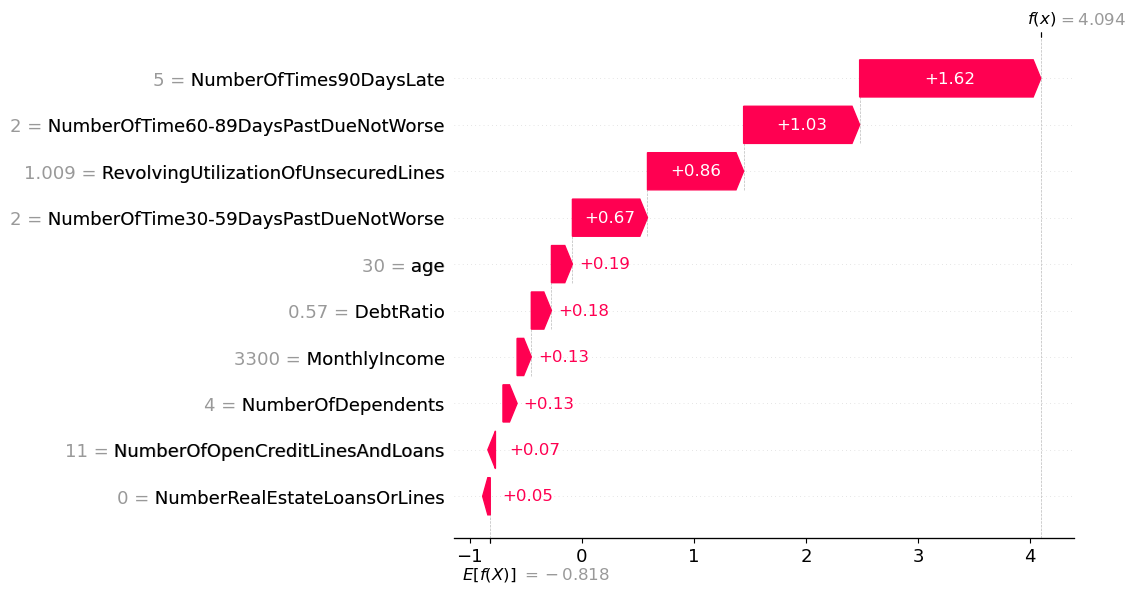

In [23]:
# Local explanation: choose a person with high default risk
index_of_interest = y_pred_proba_xgb.argmax() #highest risk
# Start new figure
plt.figure()
shap.plots.waterfall(shap_values[index_of_interest], show=False)
plt.savefig("figures/shap_waterfall_high_risk.png", bbox_inches='tight', dpi=300)
plt.close()

# Re-display the same plot in notebook
shap.plots.waterfall(shap_values[index_of_interest])